# Generating signals

There are now Python packages available on `brutha` that you can use to generate your own inspiral, or other, signals. These are available in the `lal` and `lalsimulation` packages.

If starting a new notebook make sure you use the "Python (GW)" option, or from an existing notebook click on "Kernel" -> "Change kernel" -> "Python (GW)".

In [1]:
%matplotlib inline
from matplotlib import pyplot as pl
import numpy as np

# import the lal and lalsimulation modules
import lal
import lalsimulation

## Inspiral signals

First we'll define functions for generating frequency and time domain inspiral signals. These call the `lalsimulation` waveform generation functions. The functions are detector and sky position independent, so do not take account antenna pattern functions. We'll get to them later! The inputs for the `SimInspiralChooseFDWaveform` that is used below can be found [here](https://lscsoft.docs.ligo.org//lalsuite/lalsimulation/group___l_a_l_sim_inspiral__c.html#ga50d4b23c4b6a80e93d4ed5ea7d90113b), and the inputs for the `SimInspiralChooseTDWaveform` can be found [here](https://lscsoft.docs.ligo.org//lalsuite/lalsimulation/group___l_a_l_sim_inspiral__c.html#gacf83b52d0d17af07f895bdcf965e25c6). A list of the allowed waveform model approximants can be found [here](https://lscsoft.docs.ligo.org//lalsuite/lalsimulation/group___l_a_l_sim_inspiral__h.html#gab955e4603c588fe19b39e47870a7b69c).

In [2]:
def fdwaveform(phiref, deltaF, m1, m2, fmin, dist, incl):
    """
    A function to generate a frequency domain inspiral waveform. This function sets spin
    parameters to zero, so all output are non-spinning waveforms. The reference frequency is set to fmin.
    
    This function does not include the antenna patterns, so is detector and sky position
    independent.

    Args:
        phiref (float): the reference phase (rads)
        deltaF (float): the frequency bin size (Hz)
        m1 (float): the mass of the first component (solar masses)
        m2 (float): the mass of the second component (solar masses)
        fmin (float): the lower bound on frequency (Hz)
        dist (float): the source distance (in Mpc)
        incl (float) the source inclination angle (rads)

    Returns:
        the plus and cross polarisation components of the signal in the frequency domain.
    """  

    approx = lalsimulation.TaylorF2 # Taylor F2 approximant (you can change this to e.g. lalsimulation.IMRPhenomPv2)
    fref = fmin
    fmax = 0. # this will terminate the signal at ISCO, otherwise it will can generate unphysical signals past ISCO 
 
    hptilde, hctilde = lalsimulation.SimInspiralChooseFDWaveform(
        m1*lal.MSUN_SI, m2*lal.MSUN_SI, 0., 0., 0., 0., 0., 0., dist*1e6*lal.PC_SI, incl,
        phiref, 0., 0., 0., deltaF, fmin, fmax, fref, None, approx)

    # return the frequency domain plus and cross waveforms
    return hptilde.data.data, hctilde.data.data


def tdwaveform(phiref, deltaT, m1, m2, fmin, fmax, dist, incl):
    """
    A function to generate a time domain inspiral waveform. This function sets spin
    parameters to zero, so all output are non-spinning waveforms. The reference frequency
    is set to fmin.
    
    This function does not include the antenna patterns, so is detector and sky position
    independent.

    Args:
        phiref (float): the reference phase (rads)
        deltaT (float): the time step size (s)
        m1 (float): the mass of the first component (solar masses)
        m2 (float): the mass of the second component (solar masses)
        fmin (float): the lower bound on frequency (Hz)
        fmax (float): the upper bound on frequency (Hz)
        dist (float): the source distance (in Mpc)
        incl (float) the source inclination angle (rads)

    Returns:
        the plus and cross polarisation components of the signal in the time domain.
    """  

    approx = lalsimulation.TaylorT2 # Taylor T2 approximant
    fref = fmin
 
    hp, hc = lalsimulation.SimInspiralChooseTDWaveform(
        m1*lal.MSUN_SI, m2*lal.MSUN_SI, 0., 0., 0., 0., 0., 0., dist*1e6*lal.PC_SI, incl,
        phiref, 0., 0., 0., deltaT, fmin, fref, None, approx)

    # return the frequency domain plus and cross waveforms
    return hp.data.data, hc.data.data


Let's create a frequency domain signal between 20 Hz and 1024 Hz at 0.1 Hz intervals, for a system consisting of a $1.5 M_{\odot}$ and $1.3 M_{\odot}$ star, with initial phase of 0.5 radians, distance of 10 Mpc, and inclination of 0.3 rads (note inclinations can be between $-\pi/2$ and $\pi/2$.

In [3]:
fmin = 20
fmax = 1024
df = 0.1

m1 = 1.5 # mass 1
m2 = 1.3 # mass 2

phiref = 0.5 # reference phase
iota = 0.3   # inclination angle

dist = 10. # distance in Mpc

hplusf, hcrossf = fdwaveform(phiref, df, m1, m2, fmin, dist, iota)

Note that the `hplus` and `hcross` values will be complex and they will be defined from 0 to `fmax`, but the values up until `fmin` will just be set to zero. Let's plot the `hplus` values.

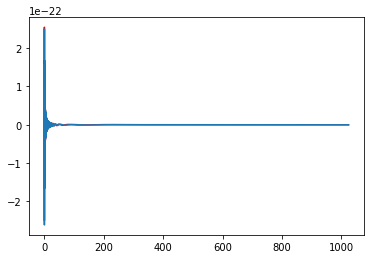

In [4]:
freqs = np.linspace(0, fmax, len(hplusf))

pl.plot(freqs, hplusf.real, 'r', freqs, hplusf.imag)

Now let's so the same in the time domain and plot it.

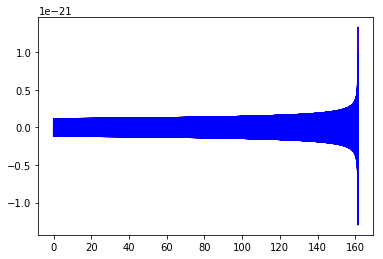

In [5]:
deltaT = 1./2048 # 2048 Hz sample rate

hplust, hcrosst = tdwaveform(phiref, deltaT, m1, m2, fmin, fmax, dist, iota)

times = np.arange(0, len(hplust)*deltaT, deltaT)

pl.plot(times, hplust, 'r', times, hcrosst, 'b')

Now we'll add antenna patterns functions that depend on the sky position of the source, polarisation and the observation time.

In [6]:
def antenna_response( gpsTime, ra, dec, psi, det ):
    """
    Get the response of a detector to plus and cross polarisation signals.
    
    Args:
        gpsTime (float): the GPS time of the observations
        ra (float): the right ascension of the source (rads)
        dec (float): the declination of the source (rads)
        psi (float): the polarisation angle of the source (rads)
        det (str): a detector name (e.g., 'H1' for the LIGO Hanford detector)
    
    Returns:
        The plus and cross response.
    """
    
    gps = lal.LIGOTimeGPS( gpsTime )
    gmst_rad = lal.GreenwichMeanSiderealTime(gps)

    # create detector-name map
    detMap = {'H1': lal.LALDetectorIndexLHODIFF,
              'H2': lal.LALDetectorIndexLHODIFF,
              'L1': lal.LALDetectorIndexLLODIFF,
              'G1': lal.LALDetectorIndexGEO600DIFF,
              'V1': lal.LALDetectorIndexVIRGODIFF,
              'T1': lal.LALDetectorIndexTAMA300DIFF}

    try:
        detector=detMap[det]
    except KeyError:
        raise ValueError("ERROR. Key {} is not a valid detector name.".format(det))

    # get detector
    detval = lal.CachedDetectors[detector]

    response = detval.response

    # actual computation of antenna factors
    fp, fc = lal.ComputeDetAMResponse(response, ra, dec, psi, gmst_rad)

    return fp, fc

So, let's create a frequency domain waveform taking into account the antenna pattern for the LIGO Hanford detector 'H1'.

In [7]:
psi = 0.6 # polarisation angle
t0 = 900000000. # GPS time of observation
ra = 4.5   # right ascension in rads
dec = -0.5 # declination in rads
det = 'H1' # LIGO Hanford

fmin = 20
fmax = 1024
df = 0.1

m1 = 1.5 # mass 1
m2 = 1.3 # mass 2

phiref = 0.5 # reference phase
iota = 0.3   # inclination angle

dist = 10. # distance in Mpc

hplusf, hcrossf = fdwaveform(phiref, df, m1, m2, fmin, dist, iota)
fp, fc = antenna_response(t0, ra, dec, psi, det)

# apply the antenna repsonse
hplusf *= fp   # multiply the plus component by fp
hcrossf *= fc  # multiply the cross component by fc

## A ring-down signal

You can also generate a ring-down signal with these codes, but only in the time domain. The ring-downs are defined by the mass and spin of the black hole, which determine the frequency and decay time (see, e.g., [Caudill _et al_, 2011](https://arxiv.org/abs/1109.5642)). The ring-down model code is defined [here](https://lscsoft.docs.ligo.org//lalsuite/lalsimulation/group___l_a_l_sim_black_hole_ringdown__h.html).

In [8]:
def tdringdown(phi0, deltaT, mass, spin, distance, incl):
    """
    Generate a time domain black-hole ring down signal. This assumesa signal from the
    l=m=2 mode.
    
    Args:
        phi0 (float): initial phase (rads)
        deltaT (float): time step for waveform generation (sec)
        mass (float): black hole mass (solar mass)
        spin (float): dimensionless spin (between 0 and 1)
        distance (float): distance (Mpc)
        incl (float): inclination angle (rads)
        
    Returns:
        plus and cross polarisations
    """

    epoch = 0. # dummy epoch
    l = m = 2  # mode
    
    hp, hc = lalsimulation.SimBlackHoleRingdown(epoch, phi0, deltaT, mass*lal.MSUN_SI, spin,
                                                1., dist*1e6*lal.PC_SI, incl, l, m)
    
    return hp.data.data, hc.data.data
    

Now let's create a ring-down signal for a $20 M_{\odot}$ star with a spin of 0.66, at a distance of 100 Mpc and an inclination of 0.5.

In [9]:
bhmass = 20.   # black hole mass
bhspin = 0.66  # black hole spin
dist = 100.    # distance
incl = 0.5     # inclination
phi0 = 0.      # initial phase

deltaT = 1/2048. # sample rate of 2048 Hz

hprd, hcrd = tdringdown(phi0, deltaT, bhmass, bhspin, dist, incl)

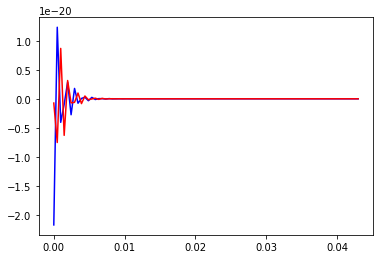

In [10]:
times = np.arange(0, deltaT*len(hprd), deltaT)

pl.plot(times, hprd, 'b', times, hcrd, 'r')

## A sine-Gaussian signal

A sine-Gaussian is a good generic signal model defined roughly:

$$
h = A\sin{(2\pi f t + \phi_0)} \exp{\left(-\frac{(t-t_0)^2}{2\tau^2}\right)}
$$

you can use `lalsimulation` to create a time domain sine-Gaussian with plus and cross polarisation components. The timescale $\tau$ is often defined in terms of the quality factor $Q$:

$$
\tau = \frac{Q}{2\pi f}
$$

In [11]:
def tdsinegaussian(phi0, deltaT, hrss, Q, freq, ecc):
    """
    Generate a time domain black-hole ring down signal. This assumesa signal from the
    l=m=2 mode.
    
    Args:
        phi0 (float): initial phase (rads)
        deltaT (float): time step for waveform generation (sec)
        hrss (float): strain amplitude at detector
        Q (float): quality factor
        freq (float): frequency of sine wave (Hz)
        ecc (float): eccentricity (between 0 and 1) (related to inclination)

    Returns:
        plus and cross polarisations
    """
    
    epoch = 0. # dummy epoch
    l = m = 2  # mode
    
    hp, hc = lalsimulation.SimBurstSineGaussian(Q, freq, hrss, ecc, phi0, deltaT)

    return hp.data.data, hc.data.data

Let's create a sine-Gaussian with $h_{\rm rss} = 5\times 10^{-21}$, $\varepsilon = 0.5$, $Q = 20$ and $f = 250$ Hz.

In [12]:
freq = 250.  # frequency
incl = 0.5   # inclination
hrss = 5e-21 # amplitude
Q = 20.      # quality
phi0 = 3.4   # phase
deltaT = 1/2048. # sample rate of 2048 Hz

hpsg, hcsg = tdsinegaussian(phi0, deltaT, hrss, Q, freq, incl)

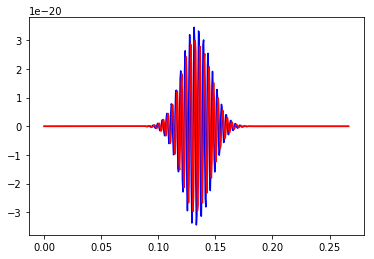

In [13]:
times = np.arange(0, deltaT*len(hpsg), deltaT)

pl.plot(times, hpsg, 'b', times, hcsg, 'r')

# Likelihood function

If performing Bayesian parameter estimation you need to compute a posterior probability function:

$$
p(\theta|\mathbf{d}) \propto p(\mathbf{d}|\theta) p(\theta)
$$

where $\theta$ is a set of parameters defining your model, $\mathbf{d}$ is your dataset, $p(\mathbf{d}|\theta)$ is the likelihood function of your data given particular model parameters $\theta$, and $p(\theta)$ is the prior probablity on $\theta$.

A common likelihood function is a Gaussian distribution (see equation 10 of [Veitch _et al_ (2014)](https://arxiv.org/abs/1409.7215) ignoring the second line for now). For data, $d$, and model, $m$, in the frequency domain, you can calculate the natural logarithm of the likelihood function with, e.g.:

$$
\ln{p(\mathbf{d}|\theta)} \equiv L \propto -\sum_{i=1}^N \frac{2\delta f \left|d_i-m_i(\theta)\right|^2}{S_n(f_i)},
$$

where the sum is over frequencies. In this $\delta f$ is the frequency step size (where $\delta f = 1/T$, for total time $T$) and $S_n(f)$ is the power spectral density. The $\left|d_i-m_i(\theta)\right|^2$ part can be expanded out to be:

$$
\left|d_i-m_i(\theta)\right|^2 = \Re{\left(d_i - m_i(\theta)\right)}^2 + \Im{\left(d_i - m_i(\theta)\right)}^2
$$

In [14]:
# create some time domain data, window it and FFT it, and calculate a PSD 
srate = 16384  # sampled a 16384 Hz
tlen = 32      # 32 seconds of data

data = 1e-20*np.random.randn(srate*tlen)

# lets we just analysis the last 4 seconds for the signal (the rest will be use for PSD calculation)
data4sig = data[-4*srate:]

# create a Tukey window for the data (see PSD section below)
from scipy.signal import welch, tukey, get_window

window = get_window(('tukey', 0.1), len(data4sig))
datawin = data4sig*window # should really do some padding here, but we'll ignore that for now

# fft the data
from numpy.fft import rfft
freqdata = rfft(datawin)

# calculate the PSD using Matplotlib's PSD function (see below) (use all the data and average 4 second segments)
from matplotlib.mlab import psd
nfft = 4*srate
psdmlab, pfreqs = psd(data, NFFT=nfft, Fs=srate, window=get_window(('tukey', 0.1), nfft), noverlap=0)

# create a frequency domain waveform at the parameters you want
phiref = 3.4 # reference phase (rads)
df = pfreqs[1]-pfreqs[0] # frequency step size
m1 = 1.5 # mass of component 1 (in solar masses)
m2 = 1.3 # mass of component 2 (in solar masses)
fmin = 20.0
dist = 10.0 # distance in Mpc
iota = 1.2 # inclination (rads)

hplusf, hcrossf = fdwaveform(phiref, df, m1, m2, fmin, dist, iota)

t0 = 900000000.0 # GPS time of signal
ra = 5.6 # right ascension (rads)
dec = -0.4 # declination in rads
psi = 1.3 # polarisation angle (rads)
det = 'H1' # detector
fp, fc = antenna_response(t0, ra, dec, psi, det)

# apply the antenna repsonse
hplusf *= fp   # multiply the plus component by fp
hcrossf *= fc  # multiply the cross component by fc

model = hplusf + hcrossf

def loglikelihood(data, model, psd, deltaF):
    """
    The log likelihood function.
    
    Args:
        data (array): the complex frequency domain data
        model (array): the complex frequency domain model
        psd (array): the power spectral density estimate
        deltaF (float): the frequency step size (1/T, or 1/(N\Delta t))
    """

    # get the difference between the data and the model
    diff = data - model
    
    # whiten this (divide by the ASD (sqrt of the PSD))
    diff /= np.sqrt(psd)

    # make sure any infinite values are zero'd (e.g. caused by ASD values that are zero)
    diff[~np.isfinite(diff)] = 0.

    # get the cross product (d-m)(d-m)*2
    chisq = np.vdot(diff, diff).real
    
    chisq *= 2*deltaF
    
    # the log likelihood function
    L = -chisq
    
    return L

# make the freq domain data the same size as the model
freqdata = freqdata[:len(model)]
psdmlab = psdmlab[:len(model)]

# get the log likelihood
logL = loglikelihood(freqdata, model, psdmlab, df)

print("log likelihood = {}".format(logL))

log likelihood = -1603278009265.452


# Generating a PSD using `lal`

There are many functions to generate a power spectral density in Python (e.g., [`scipy.signal.welch`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.welch.html), [`matplotlib.pyplot.psd`](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.psd.html), or [`matplotlib.mlab.psd`](https://matplotlib.org/api/mlab_api.html#matplotlib.mlab.psd)), but we can also do it using the functions within `lal`. This is a bit more involved, but it lets us reproduce actual analysis more precisely (although we'll see that the Welch method PSD from `lal` and Python are the same, which we would expect). Here we will be generating one-sided PSDs.

First-up we'll create a PSD using `lal`. The setting used below generate 4 seconds of data sampled at 16384 Hz. The PSD is calculated using the mean of 4 one-second spectra, with the time series data windowed with a [Tukey](https://en.wikipedia.org/wiki/Window_function#Tukey_window) window, and with no overlap.

In [15]:
# to use the LAL PSD function we need our time series data in the for of a `REAL8TimeSeries`
time = lal.LIGOTimeGPS(900000000, 0) # set a GPS epoch for the time series (this can just be a "dummy" value)

srate = 16384    # the sample rate of the time series data in Hz
length = 4*16384 # the number of samples in the time series data
nfft = 16384     # number of time samples to use per FFT
stride = 16384   # the "stride" for the next FFT (dictates how many FFTs are averaged and overlap) 

deltaT = 1./srate # time step size
data = lal.CreateREAL8TimeSeries("time data", time, 0.0, deltaT, lal.DimensionlessUnit, length)

# create some random data using numpy
npd = np.random.randn(length)
for i, d in enumerate(npd):
    data.data.data[i] = npd[i] # put the data into the REAL8TimeSeries

# create a window function to apply to the data
alpha = 0.1
window = lal.CreateTukeyREAL8Window(nfft, alpha)

# create an "FFT plan"
FFTPlan = lal.CreateForwardREAL8FFTPlan(nfft, 1)

# create a frequency series `REAL8FrequencySeries` object into which the PSD will be output
deltaF = srate/nfft     # frequency step size
nbin = int((nfft/2)+1)  # number of frequency bins
psdlal = lal.CreateREAL8FrequencySeries("spectrum", time, 0.0, deltaF, lal.DimensionlessUnit, nbin)

# create the PSD using the Welch method
lal.REAL8AverageSpectrumWelch(psdlal, data, nfft, stride, window, FFTPlan);

Now we'll do the same thing using the `scipy` and `matplotlib` functions to check that they match. As above, we calculate the mean of 2 one-second spectra windowed with the same window function.

In [16]:
from scipy.signal import welch, tukey, get_window

freqs, psdsp = welch(data.data.data, fs=srate, window=('tukey', alpha), nperseg=nfft,
                     return_onesided=True, noverlap=0)

In [17]:
from matplotlib.mlab import psd

# note that the outputs of this function are the opposite way round compared to the scipy function
psdmlab, freqs = psd(data.data.data, NFFT=nfft, Fs=srate, window=get_window(('tukey', alpha), nfft), noverlap=0)

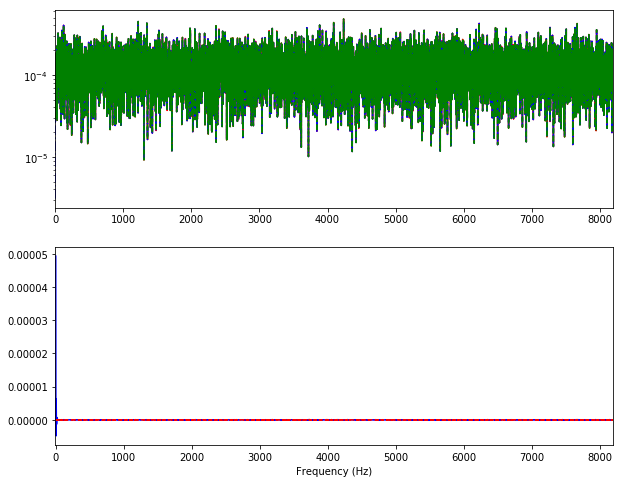

In [18]:
fig, ax = pl.subplots(2, 1, figsize=(10,8))

# plot psd on top of each other
ax[0].semilogy(freqs, psdlal.data.data, 'r')
ax[0].semilogy(freqs, psdsp, 'b-.')
ax[0].semilogy(freqs, psdmlab, 'g--')
ax[0].set_xlim([0., freqs[-1]])

# check that they're the same by plotting differences
ax[1].plot(freqs, psdlal.data.data - psdsp, 'b')
ax[1].plot(freqs, psdlal.data.data - psdmlab, 'r--')
ax[1].set_xlim([freqs[0]-10., freqs[-1]])
ax[1].set_xlabel('Frequency (Hz)');

We can see from above that the `matplotlib.mlab.psd` function and the output of the `lal` function are identical. The output of the `scipy.signal.psd` function is almost identical to the `lal` function except for a spike at 0 Hz.

There is a also a function in `lal` that uses the median, rather than the mean of the spectra. This is the default used by the CBC parameters estimation codes. The can be used as follows: 

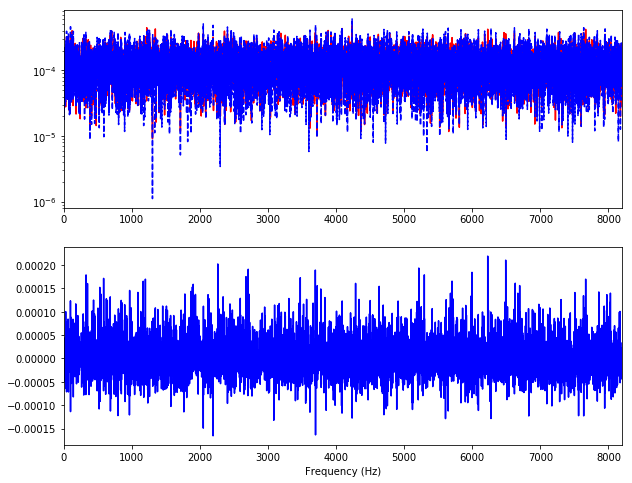

In [19]:
psdlalmedian = lal.CreateREAL8FrequencySeries("spectrum", time, 0.0, deltaF, lal.DimensionlessUnit, nbin)
# create the PSD using the median method
lal.REAL8AverageSpectrumMedian(psdlalmedian, data, nfft, stride, window, FFTPlan);

fig, ax = pl.subplots(2, 1, figsize=(10,8))
# plot the mean and median methods and their difference
ax[0].semilogy(freqs, psdlal.data.data, 'r')
ax[0].semilogy(freqs, psdlalmedian.data.data, 'b--')
ax[0].set_xlim([freqs[0], freqs[-1]])

# check that they're the same by plotting differences
ax[1].plot(freqs, psdlal.data.data - psdlalmedian.data.data, 'b')
ax[1].set_xlim([freqs[0], freqs[-1]])
ax[1].set_xlabel('Frequency (Hz)');

# Time of arrival differences

Signals from different parts of the sky will arrive at a detector at difference times. There are `lal` functions that let you work out these differences.

The [`TimeDelayFromEarthCenter`](https://lscsoft.docs.ligo.org/lalsuite/lal/_time_delay_8c_source.html#l00083) function will tell you the difference between an arrival time at the geocentre and a given detector. The [`ArrivalTimeDiff`](https://lscsoft.docs.ligo.org/lalsuite/lal/_time_delay_8c_source.html#l00037) function will tell you the arrival time difference between two detectors.

In [21]:
# set the GPS arrival time at the geocentre (first argument is the seconds, and second argument is nanosecond)
gpsseconds = 900000000 # this will give a GPS time of 900000000.5
gpsnanoseconds = 50000000
time = lal.LIGOTimeGPS(gpsseconds, gpsnanoseconds)

# create detector-name map
detMap = {'H1': lal.LALDetectorIndexLHODIFF,
          'H2': lal.LALDetectorIndexLHODIFF,
          'L1': lal.LALDetectorIndexLLODIFF,
          'G1': lal.LALDetectorIndexGEO600DIFF,
          'V1': lal.LALDetectorIndexVIRGODIFF,
          'T1': lal.LALDetectorIndexTAMA300DIFF}

# let's choose 'H1'
detval = lal.CachedDetectors[detMap['H1']]

# set a right ascension and declination
ra = -0.6
dec = 1.2

tdelay = lal.TimeDelayFromEarthCenter(detval.location, ra, dec, time)

print('Time delay from Earth geocenter to H1 is {} seconds'.format(tdelay))

# get the time delay between two detectors (H1 and L1) for a given sky position
detvalL1 = lal.CachedDetectors[detMap['L1']]
tdelaydet = lal.ArrivalTimeDiff(detval.location, detvalL1.location, ra, dec, time)

print('Time delay between H1 and L1 is {} seconds'.format(tdelaydet))

Time delay from Earth geocenter to H1 is -0.014597986592774018 seconds
Time delay between H1 and L1 is -0.00742868462011959 seconds
